<a href="https://colab.research.google.com/github/lsmanoel/Python_DSP/blob/master/DynamicBehaviorPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# !pip install slycot   # optional
!pip install control

In [0]:
import seaborn as sns # results in a look people say is modern
import numpy as np
import scipy as sp
from scipy import arange 

#-------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.pyplot  import *
%matplotlib inline

#plt.rcParams['figure.figsize'] = (20.0, 15.0) # figure size for static inline plots

#%matplotlib nbagg 
# inline figures become interactive

#%matplotlib qt 
# in case non-inline / external figures are wanted
#-------------------------------------------------------------------------------

import control as pc
from control.matlab import * 

[python-control documentation](https://python-control.readthedocs.io/en/0.8.1/intro.html)

[github.com/python-control](https://github.com/python-control)

# Sallen–Key Low-Pass topology 

> ![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Sallen-Key_Lowpass_General.svg/1024px-Sallen-Key_Lowpass_General.svg.png)


**Represetation with Transfer Function:**
$$
	G(s) = \frac{1}{R_1R_2C_1C_2s^2 + (R_1+R_2)C_2s + 1}
$$

In [0]:
R1 = 68.0e3
R2 = 16.0e3
C1 = 680.0e-9
C2 = 100.0e-9

Gs = pc.tf([1.], [R1*R2*C1*C2, (R1+R2)*C2, 1])  # first order system   
display(Gs)


              1
----------------------------
7.398e-05 s^2 + 0.0084 s + 1

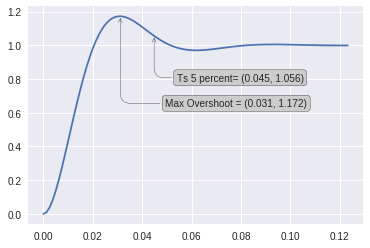

In [0]:
(y, t) = step(Gs)

fig, ax = plt.subplots()
ax.plot(t, y)

#===============================================================================
bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle = "->",
    connectionstyle = "angle,angleA=0,angleB=90,rad=10")

#-------------------------------------------------------------------------------
max_overshot = (t[np.argmax(y)], np.max(y))

offset = 90
ax.annotate('Max Overshoot = (%.3f, %.3f)'%max_overshot,
            max_overshot, 
            xytext=(0.5*offset, -offset), 
            textcoords='offset points',
            bbox=bbox, 
            arrowprops=arrowprops)

#-------------------------------------------------------------------------------
y_offset = y - 1.05
ts_5_arg = np.argmin(abs(y_offset))
ts_5 = (t[ts_5_arg], y[ts_5_arg])


offset = 45
ax.annotate('Ts 5 percent= (%.3f, %.3f)'%ts_5,
            ts_5, 
            xytext=(0.5*offset, -offset), 
            textcoords='offset points',
            bbox=bbox, 
            arrowprops=arrowprops)

#-------------------------------------------------------------------------------
plt.show()

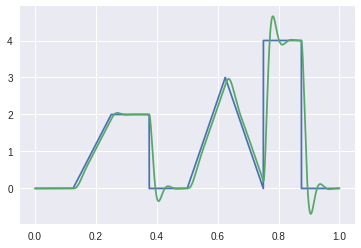

In [0]:
import numpy as np
import matplotlib.pyplot as plt

fs = 8000
Ts = 1/fs

u_zero = np.zeros(fs)
u_one = np.ones(fs)
u_ramp = np.linspace(0, 1, fs)

u=np.concatenate((u_zero, 2*u_ramp), axis=0)
u=np.concatenate((u, 2*u_one), axis=0)
u=np.concatenate((u, u_zero), axis=0)
u=np.concatenate((u, 3*u_ramp), axis=0)
u=np.concatenate((u, -3*u_ramp + 3), axis=0)
u=np.concatenate((u, u_one + 3), axis=0)
u=np.concatenate((u, u_zero), axis=0)

t = np.linspace(0, 1, 8*fs)
plt.plot(t, u)

Ts, yout, xout = pc.forced_response(Gs, t, u)

plt.plot(t, yout)

---
# Dataset Generator:





In [0]:
class ShapesSeriesData():
  
  def __init__(self):
    print("ShapeSeriesData Instantiated")
    
  #-----------------------------------------------------------------------------  
  def mount_ShapeSeries(self, shape_Num, shape_Size, shape_MaxOrder):    
    shape_MaxSize = shape_Num
    ShapeSeries  = np.ones((shape_Num, shape_Size, 1))
    start_lavel = 1e-15
    for i in range(ShapeSeries.shape[0]):
      
      shape= self.next_random_shape(last_lavel = start_lavel, 
                                    shape_MaxSize = shape_Size, 
                                    shape_MaxOrder = shape_MaxOrder)
        
      ShapeSeries[i,:, 0] = start_lavel*ShapeSeries[i,:, 0]
      ShapeSeries[i,-len(shape):, 0] = shape[:, 0]
      
    return ShapeSeries

  #-----------------------------------------------------------------------------
  def next_random_shape(self, last_lavel, shape_MaxSize, shape_MaxOrder):

    rand_size = int(shape_MaxSize*(0.80+0.20*np.random.rand()))+1

    rand_order = int(shape_MaxOrder*np.random.rand())

    rand_level = np.random.rand()
    
    datafeed = rand_level*np.ones((rand_size, 1))
    if rand_order > 0:
      for _ in range(rand_order):
        datafeed[:,0] = (datafeed[:,0]/datafeed[0,0])*np.linspace(last_lavel, rand_level, rand_size)

    return datafeed

  #-----------------------------------------------------------------------------
  def next_batch(self, datafeed):
    return datafeed[:, :-1].reshape(-1, datafeed.shape[1]-1, 1), datafeed[:, 1:].reshape(-1, datafeed.shape[1]-1, 1) 


In [0]:

shapeGen = ShapesSeriesData()

ShapeSeriesData Instantiated


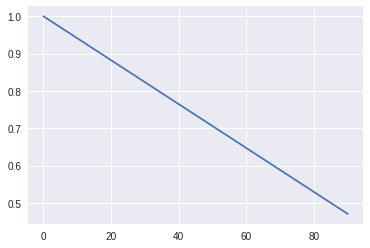

In [0]:
fs=8000
Ts = 1/fs

u = np.ones(1)
u = shapeGen.next_random_shape(last_lavel = u[-1], shape_MaxSize=100, shape_MaxOrder=3)

t = np.linspace(0, len(u)*Ts, len(u))

plt.plot(u)

In [0]:
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import control as pc
from control.matlab import * 
from sklearn.model_selection import train_test_split

fs=8000
Ts = 1/fs

shape_Num = 500
shape_Size = 1000
shape_InputSize = 250
shape_MaxOrder=3
shape_InputSize_Num = int(shape_Size/shape_InputSize)
block_Roll_Size = (shape_Size-shape_InputSize+1) 
shape_Roll_Size = shape_Num*block_Roll_Size

r = shapeGen.mount_ShapeSeries(shape_Num=shape_Num,
                               shape_Size=shape_Size,
                               shape_MaxOrder=shape_MaxOrder)

t = np.linspace(0, shape_Size*Ts, shape_Size)

print(r.shape, t.shape)


c = np.zeros(r.shape)
c_roll = np.zeros((shape_Roll_Size, shape_InputSize, 1))
print(c.shape, c_roll.shape)

scaler = MinMaxScaler(feature_range=(0, 1))

for i in range(shape_Num):
  scaler = scaler.fit(r[i,:, :])
  r[i,:, :]= scaler.transform(r[i,:, :])
  t, c[i, :, 0], xout = pc.forced_response(Gs, t, r[i,:, 0])
  for j in range(block_Roll_Size):
    c_roll[i*block_Roll_Size + j, :, 0] = c[i, j:j+shape_InputSize, 0]    
print(c.shape, c_roll.shape)

x_data, y_data = shapeGen.next_batch(c_roll)
print(x_data.shape, y_data.shape)

splitDataPercent = 0.5
train_x_data, test_x_data, train_y_data, test_y_data = train_test_split(x_data, 
                                                                        y_data, 
                                                                        test_size=splitDataPercent,
                                                                        shuffle = False)

print(test_x_data.shape, train_x_data.shape, test_y_data.shape, train_y_data.shape)  

test_data = (test_x_data, test_y_data)
train_data = (train_x_data, train_y_data)

(500, 1000, 1) (1000,)
(500, 1000, 1) (375500, 250, 1)
(500, 1000, 1) (375500, 250, 1)
(375500, 249, 1) (375500, 249, 1)
(187750, 249, 1) (187750, 249, 1) (187750, 249, 1) (187750, 249, 1)


index: 331


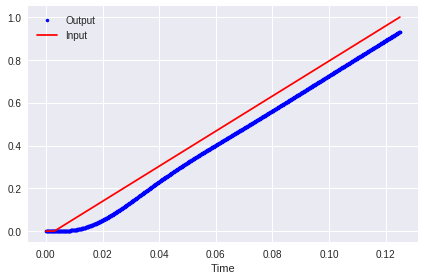

In [0]:
rand_index = int(shape_Num*np.random.rand())
plt.plot(t, c[rand_index, :], "b.", markersize=7, label="Output")
plt.plot(t, r[rand_index, :], "r", markersize=3, label="Input")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
print("index:", rand_index)

index: 331


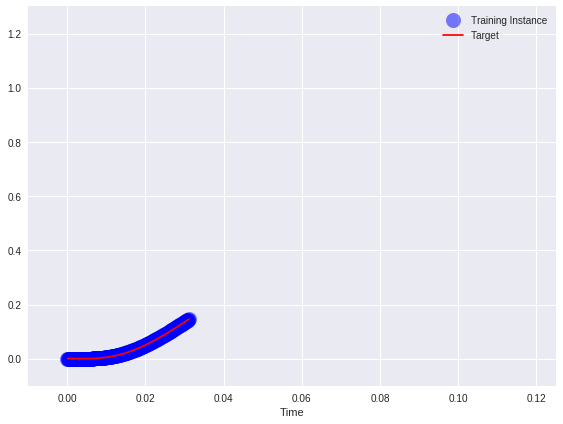

In [0]:
view_1_slider = 0 #@param {type:"slider", min:0, max:1, step:0.001}

setting_block = int(block_Roll_Size*view_1_slider)
setting_index = shape_Size*rand_index +  setting_block
plt.figure(1, figsize=(8, 6))
plt.plot(t[  setting_block:setting_block+shape_InputSize-1], x_data[setting_block+rand_index*block_Roll_Size, :shape_InputSize-1, 0], "bo", markersize=15,alpha=0.5, label="Training Instance")
plt.plot(t[1+setting_block:setting_block+shape_InputSize  ], y_data[setting_block+rand_index*block_Roll_Size, :shape_InputSize-1, 0], "r", markersize=8, label="Target")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.xlim([-0.01, Ts*shape_Size])
plt.ylim([-0.1, 1.3])

print("index:", rand_index)

index: 1


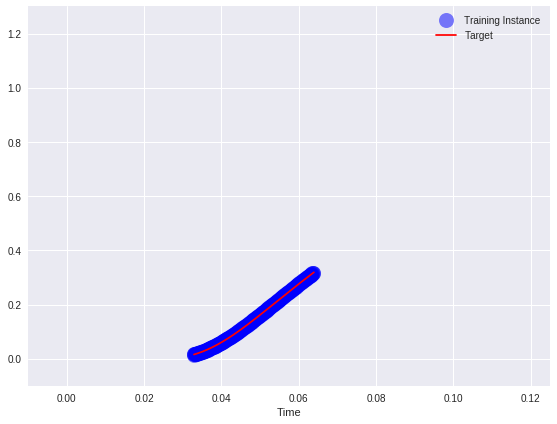

In [0]:
rand_index = 1
view_1_slider = 0.766 #@param {type:"slider", min:0, max:1, step:0.001}

setting_block = int(block_Roll_Size*view_1_slider)
setting_index = shape_Size*rand_index +  setting_block
plt.figure(1, figsize=(8, 6))
plt.plot(t[  setting_block:setting_block+shape_InputSize-1], test_x_data[setting_block+rand_index*block_Roll_Size, :shape_InputSize-1, 0], "bo", markersize=15,alpha=0.5, label="Training Instance")
plt.plot(t[1+setting_block:setting_block+shape_InputSize  ], test_y_data[setting_block+rand_index*block_Roll_Size, :shape_InputSize-1, 0], "r", markersize=8, label="Target")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.xlim([-0.01, Ts*shape_Size])
plt.ylim([-0.1, 1.3])

print("index:", rand_index)

---
# RNN

In [0]:
import tensorfcw as tf
tf.reset_default_graph()

### Constants

In [0]:
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer, play with this
num_neurons = 10
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0001
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 2000

**Dataset Iterator and Placeholders:**

In [0]:
tf.random_uniform([4, 10])

<tf.Tensor 'random_uniform:0' shape=(4, 10) dtype=float32>

In [0]:
import tensorflow as tf

X = tf.placeholder(tf.float32, [None, shape_InputSize-1, num_inputs])
y_true = tf.placeholder(tf.float32, [None, shape_InputSize-1, num_outputs])


BATCH_SIZE = 1
batch_size = tf.placeholder(tf.int64)
train_dataset = tf.data.Dataset.from_tensor_slices((X, y_true)).batch(batch_size).shuffle(buffer_size=batch_size).repeat(None)
test_dataset = tf.data.Dataset.from_tensor_slices((X, y_true)).batch(batch_size).repeat(None)

# create a iterator of the correct shape and type
iter = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)

X_input, y_true_input = iter.get_next()

# create the initialisation operations
train_init_op = iter.make_initializer(train_dataset)
test_init_op = iter.make_initializer(test_dataset)

____
____
### RNN Cell Layer

Play around with the various cells in this section, compare how they perform against each other.

In [0]:
import tensorflow as tf

# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
#     output_size=num_outputs)

# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.nn.rnn_cell.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
#     output_size=num_outputs)


In [0]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [0]:
# n_neurons = 100
# n_layers = 3

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
#           for layer in range(n_layers)])

In [0]:
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

In [0]:
# n_neurons = 100
# n_layers = 3

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
#           for layer in range(n_layers)])

---
---

### Dynamic RNN Cell

In [0]:
y, states = tf.nn.dynamic_rnn(cell, X_input, dtype=tf.float32)

### Loss Function and Optimizer

In [0]:
loss = tf.reduce_mean(tf.square(y - y_true_input)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

#### Init Variables

In [0]:
init = tf.global_variables_initializer()

## Session

In [0]:
# ONLY FOR GPU USERS:
# https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [0]:
saver = tf.train.Saver()

init iterator...
Training...
Iter: 4000	||timeStamp: 1547907302.53, timeRate: -1547907160.93	||Loss: 0.024141908622827033
Iter: 8000	||timeStamp: 141.61, timeRate: 139.77	||Loss: 0.002551690890943064
Iter: 12000	||timeStamp: 281.37, timeRate: 139.32	||Loss: 0.00024282754990076683
Iter: 16000	||timeStamp: 420.70, timeRate: 139.11	||Loss: 0.0004904151706657558
Iter: 20000	||timeStamp: 559.81, timeRate: 139.50	||Loss: 8.83894536043499e-05
Iter: 24000	||timeStamp: 699.31, timeRate: 140.58	||Loss: 3.074578288655516e-05
Iter: 28000	||timeStamp: 839.89, timeRate: 139.93	||Loss: 7.3197727773823825e-06
Iter: 32000	||timeStamp: 979.82, timeRate: 141.22	||Loss: 1.9930648581514277e-06
Iter: 36000	||timeStamp: 1121.04, timeRate: 139.57	||Loss: 8.204663802682255e-07
Iter: 40000	||timeStamp: 1260.61, timeRate: 140.32	||Loss: 1.1987040850520713e-06


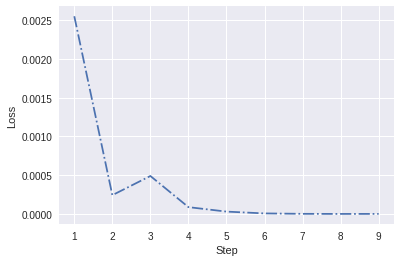

Testing...
Iter: 0, Loss: 0.00012425454042386264
Iter: 1, Loss: 0.00012425454042386264
Iter: 2, Loss: 0.00012425454042386264
Iter: 3, Loss: 0.00012425454042386264
Iter: 4, Loss: 0.00012425454042386264
Iter: 5, Loss: 0.00012425454042386264
Iter: 6, Loss: 0.00012425454042386264
Iter: 7, Loss: 0.00012425454042386264
Iter: 8, Loss: 0.00012425454042386264
Iter: 9, Loss: 0.00012425454042386264
Test Loss: 0.00012425454042386264


In [0]:
import numpy as np
import tensorflow as tf


with tf.Session() as sess:
    sess.run(init)
    
    # ==========================================================================
    # initialise iterator with train data
    print('init iterator...')
    sess.run(train_init_op, feed_dict = {X : train_data[0], 
                                         y_true: train_data[1],
                                         batch_size: BATCH_SIZE})
    
    
    print('Training...')
    j=0;
    EPOCHS = 40000
    printStep = int(EPOCHS/10)
    lossResultList = []
    epochList = []
    
    timeStamp_list = []
    time_rate_list = []
    timeStamp_list.append(time.time())
    
    for i in range(int(EPOCHS/printStep)):
      tot_loss = 0
      for _ in range(printStep):
          #print('Training---')
          _, loss_value= sess.run([train, loss])
          j+=1
          #print('Training:', j)
          tot_loss += loss_value

      lossResultList.append(tot_loss/printStep)
      epochList.append(i)
      timeStamp_list.append(time.time() - timeStamp_list[0])
      time_rate_list.append(timeStamp_list[i+1] - timeStamp_list[i])
      print("Iter: {}\t||timeStamp: {:.2f}, timeRate: {:.2f}\t||Loss: {}".format(j, 
                                                 timeStamp_list[i],
                                                 time_rate_list[i],
                                                 tot_loss/printStep))
    
    plt.plot(epochList[1:], lossResultList[1:], '-.')     
    plt.ylabel('Loss')
    plt.xlabel('Step')
    plt.show() 
    
    # ==========================================================================
    # initialise iterator with test data
    sess.run(test_init_op, feed_dict = {X : test_data[0], 
                                        y_true: test_data[1],
                                        batch_size:BATCH_SIZE})
    
    print('Testing...')
    j=0;
    full_loss = 0
    EPOCHS = 10
    for i in range(EPOCHS):
        tot_loss = 0
        for _ in range(BATCH_SIZE):
            #print('Training---')
            loss_value = sess.run(loss)
            j+=1
            #print('Training:', j)
            tot_loss += loss_value
            full_loss += loss_value
            
        print("Iter: {}, Loss: {}".format(i, 
                                          tot_loss / BATCH_SIZE))
    
    print("Test Loss: {}".format(full_loss/j))
    
    # Save Model for Later
    saver.save(sess, "./DynamicBehaviorPredictor_model")

### Predicting a time series t+1

In [0]:
test_data[0].shape

(187750, 249, 1)

INFO:tensorflow:Restoring parameters from ./DynamicBehaviorPredictor_model
(1, 249, 1) (1, 249, 1)
(249,) (249,)
(999,) (999,)
(1000,)


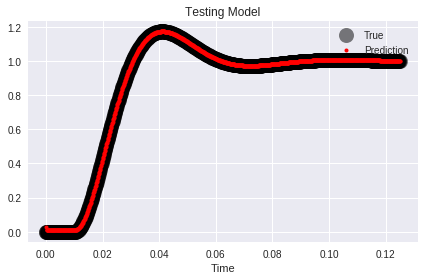

In [0]:
n_Blocks = 400
index = 3
with tf.Session() as sess:                          
    saver.restore(sess, "./DynamicBehaviorPredictor_model")   
    
    sess.run(test_init_op, feed_dict = {X : (test_data[0])[block_Roll_Size*index:, :, :], 
                                        y_true: (test_data[1])[block_Roll_Size*index:, :, :],
                                        batch_size: 1})
    
    y_pred_shape, y_true_shape = sess.run([y, y_true_input])  
    y_pred_result, y_true_result =  y_pred_shape[0, :, 0], y_true_shape[0, :, 0]

    print(y_pred_shape.shape, y_true_shape.shape)
    print(y_pred_result.shape, y_true_result.shape)

    for i in range(block_Roll_Size-1):
      y_pred_shape, y_true_shape = sess.run([y, y_true_input])    
      y_pred_result = np.append(y_pred_result, y_pred_shape[0, -1, 0])
      y_true_result = np.append(y_true_result, y_true_shape[0, -1, 0])
      
print(y_pred_result.shape, y_true_result.shape)
print(t.shape)
plt.title("Testing Model")

plt.plot(t[:-1], y_true_result, "ko", markersize=15,alpha=0.5, label="True")
plt.plot(t[1: ], y_pred_result, "r.", markersize=8, label="Prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()